In [2]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import uproot
import pandas as pd
from scipy.optimize import fsolve, curve_fit
from scipy.stats import norm

from root_to_np import get_tree, get_df, rename_tree_branches


In [3]:
pad =3
index = pad-1

run = [627,632]
pad_name = [37,38,27,28]

which_mcp = np.array([[1,2,4],[1,2,4],[5,6,7],[5,6,7]])

In [5]:
data =[]
run = [460]
for irun in run:
    tree = get_tree(irun)
    var_indexes = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39])
    data_single = get_df(tree,*var_indexes)
    old_names = ['MCP1_global_maximum_y','MCP1_all_charge','MCP1_sigmoid_timepoint','MM1_global_maximum_y','MM1_e_charge','MM1_all_charge','MM1_sigmoid_timepoint', 'TrackChi2', 'NumberofTracks',  'SRSnumber']
    new_names = ['mcp1_gpeak','mcp1_qall','mcp1_t','mm1_gpeak','mm1_qe', 'mm1_qall','mm1_tfit','chi2', 'track_flag',  'SRSnumber']
    names = [old_names,new_names]
    data_single = rename_tree_branches(data_single,*names)
    print(len(data_single))
    data.append(data_single)

# Concatenate the list of DataFrames into a single DataFrame
data = pd.concat(data)
print(data.head())
print(len(data))

FileNotFoundError: file not found

    '/home/evridiki/Downloads/test_run460.root'

Files may be specified as:
   * str/bytes: relative or absolute filesystem path or URL, without any colons
         other than Windows drive letter or URL schema.
         Examples: "rel/file.root", "C:\abs\file.root", "http://where/what.root"
   * str/bytes: same with an object-within-ROOT path, separated by a colon.
         Example: "rel/file.root:tdirectory/ttree"
   * pathlib.Path: always interpreted as a filesystem path or URL only (no
         object-within-ROOT path), regardless of whether there are any colons.
         Examples: Path("rel:/file.root"), Path("/abs/path:stuff.root")

Functions that accept many files (uproot.iterate, etc.) also allow:
   * glob syntax in str/bytes and pathlib.Path.
         Examples: Path("rel/*.root"), "/abs/*.root:tdirectory/ttree"
   * dict: keys are filesystem paths, values are objects-within-ROOT paths.
         Example: {"/data_v1/*.root": "ttree_v1", "/data_v2/*.root": "ttree_v2"}
   * already-open TTree objects.
   * iterables of the above.


# CALCULATIONS

In [4]:
#%jsroot on

In [5]:
mcp_overflow = (data.mcp_gpeak>0.)*(data.mcp_gpeak<=0.72)
chi2_cut = (data.chi2<=40)*(data.track_flag>0)

mcp_basic_cut = mcp_overflow*chi2_cut

In [6]:
c = ROOT.TCanvas()

xytrks = ROOT.TH2F("xytrks",f'RUN{run}: All tracks multiplicity',100,0,50,100,0,50)

xytrks.GetXaxis().SetTitle("x")
xytrks.GetYaxis().SetTitle("y")

n = len(data[mcp_basic_cut])
x = data.iloc[:,-4][mcp_basic_cut].values
y = data.iloc[:,-3][mcp_basic_cut].values
w = np.ones(n)
xytrks.FillN(n,x,y,w)

for i in range(xytrks.GetNbinsX()+1):
    for j in range(xytrks.GetNbinsY()+1):
        if xytrks.GetBinContent(i,j)<15:
            xytrks.SetBinContent(i,j,0)

xytrksW = ROOT.TH2F("xytrksW",f'RUN{run}: xy tracks weighted by MCP charge',100,0,50,100,0,50)
xytrksW.GetXaxis().SetTitle("x [mm]")
xytrksW.GetYaxis().SetTitle("y [mm]")

w = data.iloc[:,1][mcp_basic_cut].values
xytrksW.FillN(n,x,y,w)

xytrksW.Divide(xytrks)

True

In [7]:
mm_gpeak = f'mm{pad}_gpeak'
mm_qall = f'mm{pad}_qall'
mm_qe = f'mm{pad}_qe'
mm_qfit = f'mm{pad}_qfit'
mm_t = f'mm{pad}_t'
mm_overflow = (data[mm_gpeak]>0.)*(data[mm_gpeak]<0.36)*(data[mm_qall]>0)
qe_line = (data[mm_qe]>30.*data[mm_gpeak])

mm_basic_cut = np.logical_and(mm_overflow*mcp_basic_cut,qe_line)


In [8]:
# we find the pad here!
    
xytrksW_mm = ROOT.TH2F(f'xytrksW{pad}',f'RUN {run}: xy tracks weighted by PAD {pad_name[index]} e-peak row charge',
                       100,0,50,100,0,50)
xytrksW_mm.GetXaxis().SetTitle("x")
xytrksW_mm.GetYaxis().SetTitle("y")

n = len(data[mm_basic_cut])
x = data.iloc[:,-4][mm_basic_cut].values
y = data.iloc[:,-3][mm_basic_cut].values
w = data.iloc[:,4][mm_basic_cut].values
xytrksW_mm.FillN(n,x,y,w)
    
xytrksW_mm.Divide(xytrks)
    

pad_hist = xytrksW_mm.Clone()
pad_hist.SetName(f'pad{pad}_hist')
pad_hist.SetTitle(f' PAD {pad_name[index]}')
for i in range(pad_hist.GetNbinsX()+1):
    for j in range(pad_hist.GetNbinsY()+1):
        if pad_hist.GetBinContent(i,j)<2.:
            pad_hist.SetBinContent(i,j,0)
    


# DISPLAY THE ONE SELECTED PAD  

In [9]:
v_limits = data[mm_gpeak]>0
qall_limits = (data[mm_qall]>0)*(data[mm_qall]<55)
qe_limits = (data[mm_qe]>0)*(data[mm_qe]<12)
qfit_limits = (data[mm_qfit]>0)*(data[mm_qfit]<12)

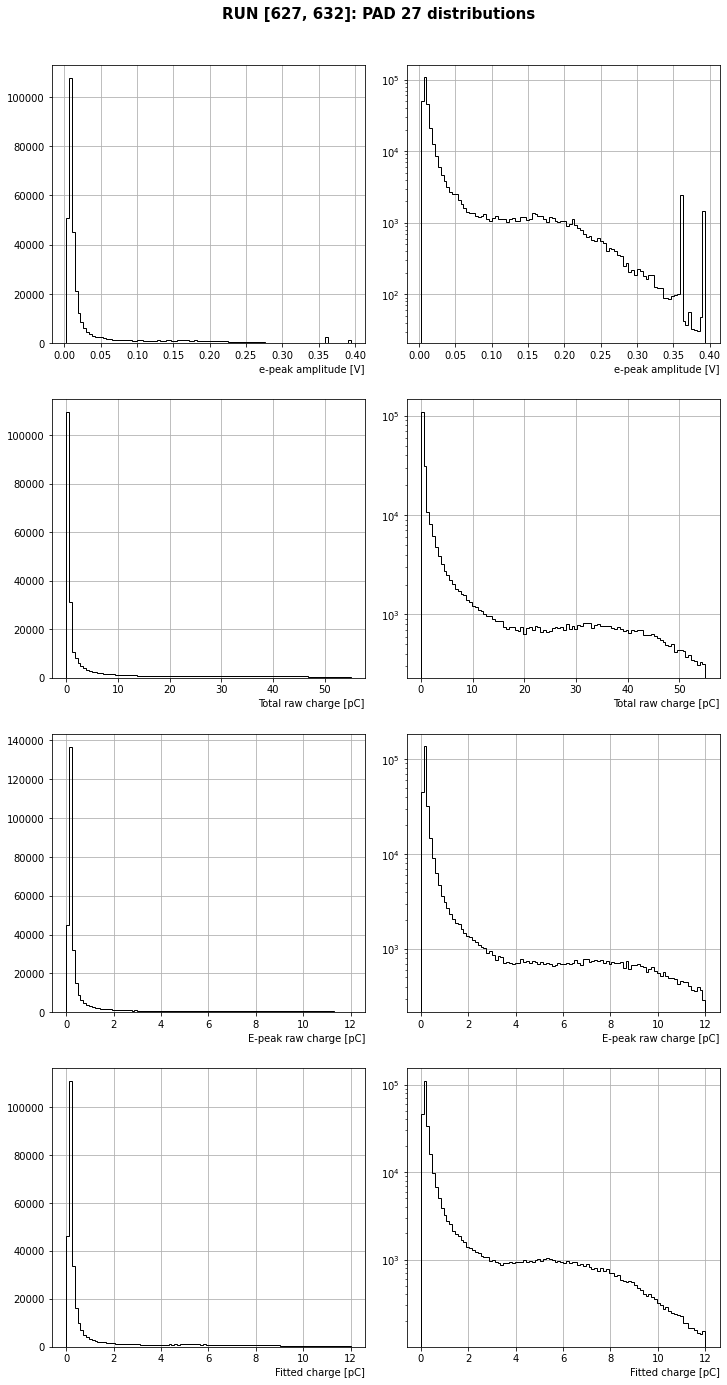

In [10]:
fig, axes = plt.subplots(4,2,figsize=(10,20))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.subplots_adjust(hspace=0.2)
fig.suptitle(f'RUN {run}: PAD {pad_name[index]} distributions', fontsize=15, fontweight='bold')


ax = axes[0][0]
ax.hist(data[mm_gpeak][v_limits], bins =100,color = 'black', histtype='step')
ax.set_xlabel('e-peak amplitude [V]',loc='right')
ax.grid()
ax = axes[0][1]
ax.hist(data[mm_gpeak][v_limits], bins =100,color = 'black', histtype='step')
ax.set_xlabel('e-peak amplitude [V]',loc='right')
ax.grid()
ax.set_yscale('log')

ax = axes[1][0]
ax.hist(data[mm_qall][qall_limits], bins =100, color = 'black', histtype='step')
ax.set_xlabel('Total raw charge [pC]',loc='right')
ax.grid()
ax = axes[1][1]
ax.hist(data[mm_qall][qall_limits], bins =100, color = 'black', histtype='step')
ax.set_xlabel('Total raw charge [pC]',loc='right')
ax.set_yscale('log')
ax.grid()

ax = axes[2][0]
ax.hist(data[mm_qe][qe_limits], bins =100, color = 'black', histtype='step')
ax.set_xlabel('E-peak raw charge [pC]',loc='right')
ax.grid()
ax = axes[2][1]
ax.hist(data[mm_qe][qe_limits], bins =100, color = 'black', histtype='step')
ax.set_xlabel('E-peak raw charge [pC]',loc='right')
ax.set_yscale('log')
ax.grid()

ax = axes[3][0]
ax.hist(data[mm_qfit][qfit_limits], bins =100, color = 'black', histtype='step')
ax.set_xlabel('Fitted charge [pC]',loc='right')
ax.grid()
ax = axes[3][1]
ax.hist(data[mm_qfit][qfit_limits], bins =100, color = 'black', histtype='step')
ax.set_xlabel('Fitted charge [pC]',loc='right')
ax.set_yscale('log')
ax.grid()


plt.show()

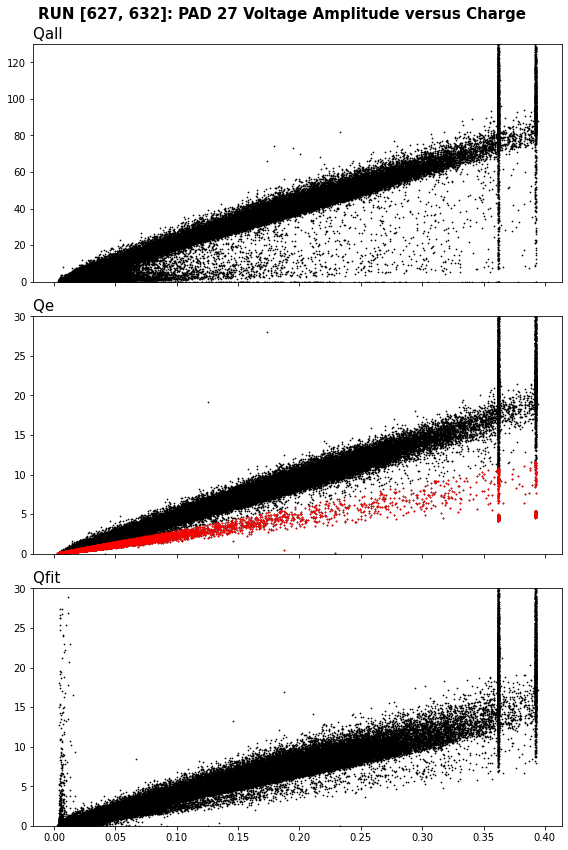

In [11]:
fig, axs = plt.subplots(3,sharex=True,figsize=(8,12))
fig.suptitle(f'RUN {run}: PAD {pad_name[index]} Voltage Amplitude versus Charge ', fontsize=15, fontweight='bold')

axs[0].scatter(data[mm_gpeak][v_limits], data[mm_qall][v_limits], color='black',s=0.5)
axs[0].set_title('Qall ', fontsize=15, color= 'black', loc='left');
axs[0].set_ylim(0,130)

axs[1].scatter(data[mm_gpeak][v_limits], data[mm_qe][v_limits], color='black',s=0.5)
axs[1].set_title('Qe ', fontsize=15, color= 'black', loc='left');
axs[1].set_ylim(0,30)
#axs[1].set_xlim(0.004,0.12)
#axs[1].set_ylim(0,6.)
line = data[mm_qe]<=30.*data[mm_gpeak]
axs[1].scatter(data[mm_gpeak][v_limits*line], data[mm_qe][v_limits*line], color='red',s=0.5)

axs[2].scatter(data[mm_gpeak][v_limits], data[mm_qfit][v_limits], color='black',s=0.5)
axs[2].set_title('Qfit ', fontsize=15, color= 'black', loc='left');
axs[2].set_ylim(0,30)
#axs[2].set_xlim(0.004,0.12)
#axs[2].set_ylim(0,6.)

fig.tight_layout()

In [12]:
%jsroot on
xytrksW_mm.Draw("lego2z")
c.Draw()

In [13]:
xytrksW_mm.Draw("colz")
c.Draw()

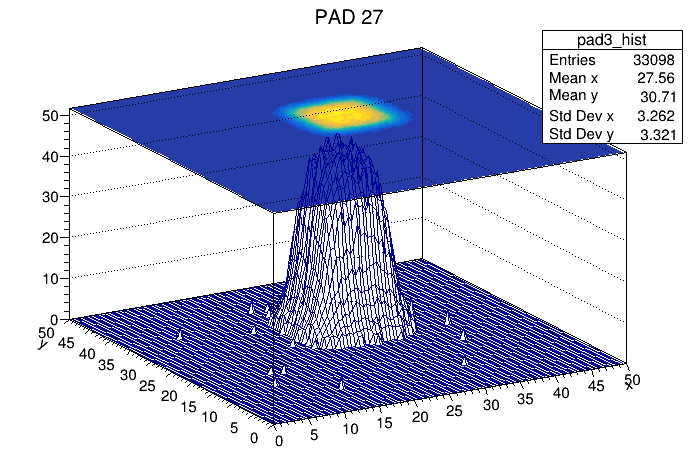

In [14]:
%jsroot off
pad_hist.Draw("surf3")
c.Draw()

## Timing properties

In [15]:
centers_from_fit = np.loadtxt('/home/evridiki/Desktop/JULY_RUNS/run_627_632_info/pad_centers.txt',
                delimiter=" ", unpack=False)
xc = centers_from_fit[0][index]
yc = centers_from_fit[1][index]

num of events 51569  and mean now  -8967.62956803895
num of events after cut 51561  and mean now  -8903.33927441917


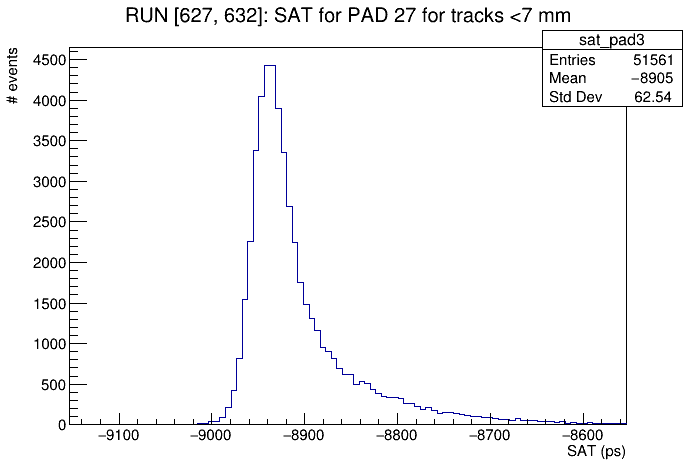

In [16]:
#circle_cut = np.sqrt((data.iloc[:,-4]-xc)**2 + (data.iloc[:,-3]-yc)**2)<7.
square_cut = np.logical_and(np.abs(data.iloc[:,-4]-xc)<7., np.abs(data.iloc[:,-3]-yc)<7.)
mm_time_cut = mm_basic_cut*(data[mm_gpeak]>0.03)*square_cut

sat = (data[mm_t][mm_time_cut] - data.mcp_t[mm_time_cut])*1000 #ps
print('num of events',len(sat),' and mean now ',sat.mean())

#in each pad remain about ~200 tracks with times waaaay out of range, so we apply a filter
sat = sat[np.abs(sat-sat.mean())<=1000]
print('num of events after cut',len(sat),' and mean now ',sat.mean())

sat_pad = ROOT.TH1F(f'sat_pad{pad}', f'RUN {run}: SAT for PAD {pad_name[index]} for tracks <7 mm', 
                    100,sat.mean()-250,sat.mean()+350)

sat_pad.GetXaxis().SetTitle("SAT (ps)")
sat_pad.GetYaxis().SetTitle('# events')

sat_pad.FillN(len(sat),sat.values,np.ones(len(sat)))

c.Clear()
sat_pad.Draw()
c.Draw()


 FCN=71.7816 FROM MIGRAD    STATUS=CONVERGED      76 CALLS          77 TOTAL
                     EDM=5.27224e-11    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     5.87452e+02   9.47458e+00   3.09704e-02  -3.52818e-07
   2  Mean        -8.94329e+03   2.03075e-01   4.26449e-03  -3.00456e-05
   3  Sigma        1.59095e+01   1.59054e-01   1.03857e-05   2.06298e-03


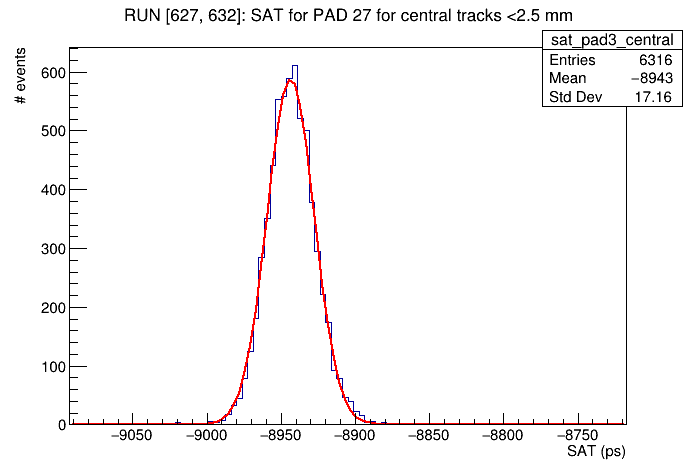

In [17]:
circle_cut = np.sqrt((data.iloc[:,-4]-xc)**2 + (data.iloc[:,-3]-yc)**2)<2.5
#square_cut = np.logical_and(np.abs(data.iloc[:,-4]-xc)<2.5, np.abs(data.iloc[:,-3]-yc)<2.5)
mm_time_cut = mm_basic_cut*(data[mm_gpeak]>0.03)*circle_cut

sat = (data[mm_t][mm_time_cut] - data.mcp_t[mm_time_cut])*1000 #ps
sat_pad_central = ROOT.TH1F(f'sat_pad{pad}_central', 
                            f'RUN {run}: SAT for PAD {pad_name[index]} for central tracks <2.5 mm',
                            100,sat_pad.GetMean()-3*sat_pad.GetStdDev(),sat_pad.GetMean()+3*sat_pad.GetStdDev())

sat_pad_central.GetXaxis().SetTitle("SAT (ps)")
sat_pad_central.GetYaxis().SetTitle('# events')

sat_pad_central.FillN(len(sat),sat.values,np.ones(len(sat)))

#c.Clear()
sat_pad_central.Fit("gaus")
sat_pad_central.Draw()
c.Draw()

# APPLY GLOBAL TIMING CORRECTION

In [18]:
cable_delay = np.loadtxt(f'/home/evridiki/Desktop/JULY_RUNS/run_{run[0]}_{run[1]}_info/cable_delay.txt')
cable_delay = cable_delay-np.ones_like(cable_delay)*4.5

#slew_par = np.loadtxt(f'/home/evridiki/Desktop/JULY_RUNS/run_627_632_info/global_slew_fit.txt')
slew_par = np.loadtxt(f'/home/evridiki/Desktop/JULY_RUNS/run_627_632_info/slew_fit.txt')

p2 = np.loadtxt('/home/evridiki/Desktop/JULY_RUNS/run_627_632_info/scale_par.txt',
                delimiter=" ", usecols=(0))
p3 = np.loadtxt('/home/evridiki/Desktop/JULY_RUNS/run_627_632_info/scale_par.txt',
                delimiter=" ", usecols=(1))

In [19]:
def double_expo(x,*p):
    return np.exp(p[0]*x+p[1])+np.exp(p[2]*x+p[3])+p[4]

In [20]:
def double_gaus( x, *params ):
    (c1, mu, sigma1, c2, sigma2) = params
    res =   c1 * np.exp( - (x - mu)**2.0 / (2.0 * sigma1**2.0) ) \
          + c2 * np.exp( - (x - mu)**2.0 / (2.0 * sigma2**2.0) )
    return res
def simple_gaus(x,c,mu,sigma):
    res =   c * np.exp( - (x - mu)**2.0 / (2.0 * sigma**2.0) ) 
    return res


In [21]:
square_cut = np.logical_and(np.abs(data.iloc[:,-4]-xc)<7., np.abs(data.iloc[:,-3]-yc)<7.)
mm_time_cut = mm_basic_cut*(data[mm_gpeak]>0.03)*square_cut

cable =cable_delay[index]-10
q_scale = p2[index]*data[mm_qall][mm_time_cut]+p3[index]
cor = double_expo(q_scale, *slew_par)
sat = ((data[mm_t][mm_time_cut] - data.mcp_t[mm_time_cut])*1000 -cable) - cor #ps
sat = sat[np.abs(sat)<=200] # times waaay out of range

counts, edges = np.histogram(sat,bins=100)
bin_centers = (edges[:-1] + edges[1:])/2
y_errors = np.sqrt(counts)


In [22]:
g2_par = np.array([3500.,0.,20,500,50])

param_bounds=([0.1,-np.inf,1.,0.1,1.],[np.inf,np.inf,np.inf,np.inf,np.inf])

popt, pcov = curve_fit(double_gaus, bin_centers, counts, p0=g2_par, bounds = param_bounds)
g2_par= popt

pcov

array([[ 1.79570856e+03,  8.07776221e-07,  6.77853178e+00,
        -1.68983618e+03,  6.09736986e+01],
       [ 8.07776221e-07,  1.34244599e-02,  3.88053227e-09,
        -8.81428689e-07,  3.99049700e-08],
       [ 6.77853178e+00,  3.88053227e-09,  6.01903785e-02,
        -8.98612704e+00,  2.86024940e-01],
       [-1.68983618e+03, -8.81428689e-07, -8.98612704e+00,
         1.88538640e+03, -6.65818817e+01],
       [ 6.09736986e+01,  3.99049700e-08,  2.86024940e-01,
        -6.65818817e+01,  2.91846277e+00]])

In [23]:
x = np.linspace(-180,180,4000)

prob =  double_gaus(x,*g2_par)/double_gaus(x,*g2_par).sum()
mu_double   = x.dot(prob)         # mean value
mom2 = np.power(x, 2).dot(prob)  # 2nd moment
var  = mom2 - mu_double**2        # variance
sigma_double = np.sqrt(var) 

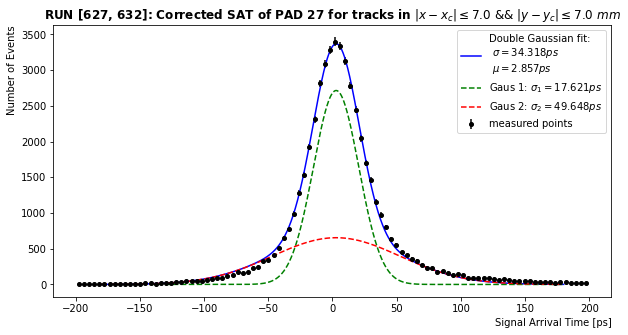

In [24]:
fig = plt.figure(figsize=(10,5))
plt.errorbar(bin_centers, counts, yerr=y_errors, fmt='o',markersize=4.,color='black',label= 'measured points')

(c1, mu, sigma1, c2, sigma2) = g2_par

plt.plot(x,double_gaus(x,*g2_par),color='blue',
         label='Double Gaussian fit:\n'+f' $\sigma = {sigma_double:.3f} ps$'+'\n'+f' $\mu ={mu:.3f} ps$')

plt.plot(x,simple_gaus(x,c1,mu,sigma1),'g--',
         label=f'Gaus 1: $\sigma_1 = {sigma1:.3f} ps$')
plt.plot(x,simple_gaus(x,c2,mu,sigma2),'r--', 
         label =f'Gaus 2: $\sigma_2 = {sigma2:.3f} ps$' )

plt.xlabel('Signal Arrival Time [ps]',loc='right')
plt.ylabel('Number of Events',loc='top')
plt.title(f'RUN {run}: Corrected SAT of PAD {pad_name[index]} for tracks in $|x-x_c|\leq 7.0\ &&\ |y-y_c|\leq 7.0\ mm$',
          fontsize=12, fontweight='bold')
plt.legend()
plt.show()

In [25]:
#repeat for central tracks

circle_cut = np.sqrt((data.iloc[:,-4]-xc)**2 + (data.iloc[:,-3]-yc)**2)<2.5
mm_time_cut = mm_basic_cut*(data[mm_gpeak]>0.03)*circle_cut

cable =cable_delay[index]-10
q_scale = p2[index]*data[mm_qall][mm_time_cut]+p3[index]
cor = double_expo(q_scale, *slew_par)
sat = ((data[mm_t][mm_time_cut] - data.mcp_t[mm_time_cut])*1000 -cable) - cor #ps
sat = sat[np.abs(sat)<=100] # times waaay out of range

counts, edges = np.histogram(sat,bins=100)
bin_centers = (edges[:-1] + edges[1:])/2
y_errors = np.sqrt(counts)


In [26]:
g2_par = np.array([350.,0.,10,50,30])

param_bounds=([0.1,-np.inf,1,0.1,1],[np.inf,np.inf,np.inf,np.inf,np.inf])

popt, pcov = curve_fit(double_gaus, bin_centers, counts, p0=g2_par, bounds = param_bounds)
g2_par= popt

pcov

array([[ 2.01313385e+03,  5.95463361e-04,  3.68366598e+01,
        -2.04390370e+03,  4.64500959e+02],
       [ 5.95463361e-04,  1.92784233e-02,  1.01919112e-05,
        -6.03385857e-04,  1.47778557e-04],
       [ 3.68366598e+01,  1.01919112e-05,  7.32597812e-01,
        -3.77633985e+01,  8.19778975e+00],
       [-2.04390370e+03, -6.03385857e-04, -3.77633985e+01,
         2.08016204e+03, -4.71483901e+02],
       [ 4.64500959e+02,  1.47778557e-04,  8.19778975e+00,
        -4.71483901e+02,  1.12087725e+02]])

In [27]:
x = np.linspace(-80,80,2000)

prob =  double_gaus(x,*g2_par)/double_gaus(x,*g2_par).sum()
mu_double   = x.dot(prob)         # mean value
mom2 = np.power(x, 2).dot(prob)  # 2nd moment
var  = mom2 - mu_double**2        # variance
sigma_double = np.sqrt(var) 

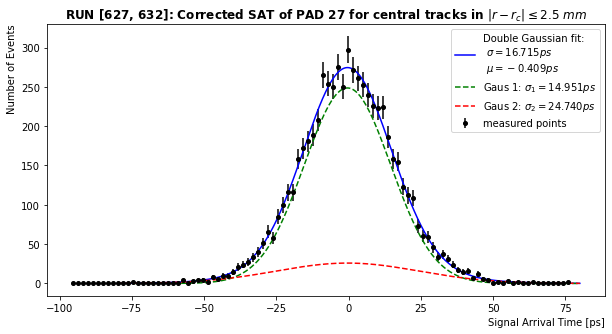

In [28]:
fig = plt.figure(figsize=(10,5))
plt.errorbar(bin_centers, counts, yerr=y_errors, fmt='o',markersize=4.,color='black',label= 'measured points')

(c1, mu, sigma1, c2, sigma2) = g2_par

plt.plot(x,double_gaus(x,*g2_par),color='blue',
         label='Double Gaussian fit:\n'+f' $\sigma = {sigma_double:.3f} ps$'+'\n'+f' $\mu ={mu:.3f} ps$')

plt.plot(x,simple_gaus(x,c1,mu,sigma1),'g--',
         label=f'Gaus 1: $\sigma_1 = {sigma1:.3f} ps$')
plt.plot(x,simple_gaus(x,c2,mu,sigma2),'r--', 
         label =f'Gaus 2: $\sigma_2 = {sigma2:.3f} ps$' )

plt.xlabel('Signal Arrival Time [ps]',loc='right')
plt.ylabel('Number of Events',loc='top')
plt.title(f'RUN {run}: Corrected SAT of PAD {pad_name[index]} for central tracks in $|r-r_c|\leq 2.5\ mm$',
          fontsize=12, fontweight='bold')
plt.legend()
plt.show()